# CNN DOA with 1 degree resolution

In [1]:
from preprocessing import *
from training import rmse
from music import get_all_predictions
from training import create_model, evaluate_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import math
import sys
import os
from collections import defaultdict
from itertools import combinations

from pyroomacoustics.transform import stft

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, Reshape
from keras.layers import Dropout
from keras.layers import Conv1D, Conv2D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
sns.set(style='whitegrid', palette='muted', font_scale=1)

from numba import cuda 

In [2]:
# Label resolution of classification
RESOLUTION = 1

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

In [3]:
def gcc_phat(x_1, x_2, FS=16000, interp=1):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
     # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n * interp)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS * interp)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def compute_gcc_matrix(observation, fs, interp=1):
    """
    Creates a GCC matrix, where each row is a vector of GCC 
    between a given pair of microphones.
    """ 
    
    mic_pairs = combinations(range(MICS_NUMBER), r=2)

    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    for mic_1, mic_2 in mic_pairs:
        x_1 = observation[:, mic_1]
        x_2 = observation[:, mic_2]

        gcc = gcc_phat(x_1, x_2, FS=fs, interp=interp)

        # Add the GCC vector to the GCC matrix
        transformed_observation.append(gcc)    
        
    return transformed_observation


def compute_stft_matrix(observation, nfft=256):
    """
    Creates a STFT matrix using microphone data from 6 channels.
    """
    
    # Default value for overlap
    step = nfft // 2
    
    # Calculate multidimensional STFT and return
    transformed_observation = stft.analysis(observation, L=nfft, hop=step)
    return np.transpose(transformed_observation, axes=[2, 1, 0])


def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=20, music=False, interp=1):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row 
    is a vector of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    rounded_label = round(label / resolution) * resolution
    if rounded_label == 360: rounded_label = 0
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        y.append(rounded_label)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        if music:
            # Transform observation into a STFT matrix
            transformed_observation = compute_stft_matrix(observation)
        else:
            # Transform observation into a GCC matrix
            transformed_observation = compute_gcc_matrix(observation, fs, interp=interp)
            
        X.append(transformed_observation)

    return X, y


def one_hot_encode(encoder, y_train, y_test):
    """
    Creates a one-hot encoding of categorical labels
    provided in y_train and y_test.
    """
    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test
  
    
def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values
    from train and tests dataframes.
    
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test


def create_dataframe(subset, plane='horizontal', samples=20, step=5, resolution=20, interp=1):
    dataframes = []
    
    files = [file for file in os.listdir(os.path.join(AUDIO_PATH, plane)) if subset in file and 'white_noise' not in file]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue
            
        print(f'{subset} file {i+1}/{len(files)}', end='\r')

        path = os.path.join(AUDIO_PATH, plane, file)
        fs, wav_signals = wavfile.read(path)
        
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, label, samples, step, resolution, interp=interp)
        
        cols = [
            f'mics{mic_1+1}{mic_2+1}_{i}' 
                for mic_1, mic_2 in combinations(range(MICS_NUMBER), r=2) 
                    for i in range(np.shape(X_temp)[2])
        ]
        
        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        df['dist'], df['room'] = dist, room
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)

### Create training and testing sets

In [4]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION, interp=2)
print()

df_train.to_csv('../training_data/super_azimuth_train_dataset.csv')
df_test.to_csv('../training_data/super_azimuth_test_dataset.csv')

# Create numpy arrays with observations and one-hot labels
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)

np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

train file 3240/3240
test file 3240/3240


((628560, 15, 25), (210740, 15, 25), (628560, 360), (210740, 360))

Only run this when all the variables are not stored in memory (i.e. after restarting the kernel):

In [4]:
df_train = pd.read_csv('../training_data/super_azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/super_azimuth_test_dataset.csv', index_col=[0])
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((628560, 15, 25), (210740, 15, 25), (628560, 360), (210740, 360))

In [14]:
def plot_gccs(angle_labels, observations):
    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle('Example GCC matrices for different angles', fontsize=18)

    for i, label in enumerate(np.unique(angle_labels)[::90]):
        ax = axs[i//2][i%2]
        indices = np.where(angle_labels == label)[0]
        obs_idx = indices[np.random.randint(len(indices))]

        observation = observations[obs_idx]

        ax.set_title(f'Angle {label}')
        im = ax.matshow(observation.T, aspect=0.5)
        fig.colorbar(im, ax=ax)

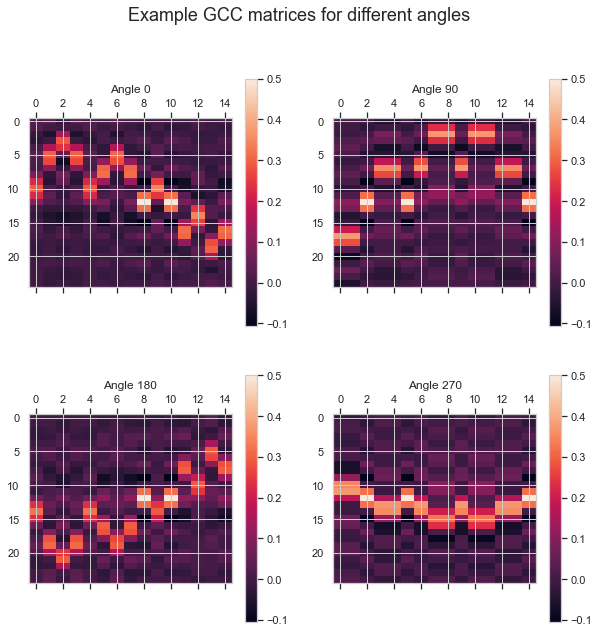

In [20]:
# Get training labels
angle_labels = encoder.inverse_transform(y_train)
plot_gccs(angle_labels, X_train)

### Fit and evaluate model

In [10]:
# Transpose the observations because Conv1D requires timesteps as the 1st dim
if X_train.shape[1] == MIC_COMBS:
    X_train, X_test = np.transpose(X_train, axes=[0, 2, 1]), np.transpose(X_test, axes=[0, 2, 1])
X_train.shape, X_test.shape

((628560, 25, 15), (210740, 25, 15))

In [7]:
epochs, batch_size, verbose = 10, 32, 1

# Fit model
def create_model(X_train, y_train, X_test, y_test, cnn_layers=5, pooling=True, lstm=False):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    
    for i in range(cnn_layers-1):
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
        
    model.add(Dropout(0.5))
    
    if pooling:
        model.add(MaxPooling1D(pool_size=2))
        
    if lstm:
        model.add(LSTM(128, return_sequences=True))
        
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model, history

Five conv. layers:

In [39]:
model, history = create_model(X_train, y_train, X_test, y_test)

Epoch 1/10
19643/19643 [==============================] - 132s 6ms/step - loss: 1.2076 - accuracy: 0.5082
Epoch 2/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.6595 - accuracy: 0.7333
Epoch 3/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.5163 - accuracy: 0.8014
Epoch 4/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.4427 - accuracy: 0.8346
Epoch 5/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.4039 - accuracy: 0.8523
Epoch 6/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.3797 - accuracy: 0.8633
Epoch 7/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.3626 - accuracy: 0.8716
Epoch 8/10
19643/19643 [==============================] - 122s 6ms/step - loss: 0.3455 - accuracy: 0.8790
Epoch 9/10
19643/19643 [==============================] - 121s 6ms/step - loss: 0.3364 - accuracy: 0.8831
Epoch 10/10
19643/19643 [=====================

In [43]:
np.save('../models/super_history.npy', history.history)

In [40]:
# Test model
accuracy = evaluate_model(model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

6586/6586 [==============================] - 24s 4ms/step - loss: 0.5749 - accuracy: 0.8259
Accuracy: 0.826
RMSE: 6.744


In [8]:
def evaluate_for_property(df_train, df_test, prop, value):
    """
    Measures the model prediction for test samples
    with a given property, such as room size.
    """
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Filter test set by property value
    X_trn, y_trn, X_tst, y_tst = create_whole_dataset(
        df_train, df_test[df_test[prop]==value], encoder
    )
    
    # Evaluate the model on the filtered set
    X_tst = np.transpose(X_tst, axes=[0, 2, 1])
    loss, acc = model.evaluate(X_tst, y_tst, batch_size=batch_size, verbose=0)
    
    return round(loss, 3), round(acc, 3)

In [42]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.823
medium room accuracy: 0.825
large room accuracy: 0.83

Distances
50 cm distance accuracy: 0.597
150 cm distance accuracy: 0.942
200 cm distance accuracy: 0.941
250 cm distance accuracy: 0.934
350 cm distance accuracy: 0.937
450 cm distance accuracy: 0.949


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            2944      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 64)            12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19, 64)            12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 64)            12352     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 15, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 15, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 64)             0

In [50]:
model.save("../models/super_model")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the Lite model.
with open('../models/super_azimuth_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/super_model\assets
INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpasv7b1lj\assets


### Run experiment with different models

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

best_accuracy = 0
best_model_specs = None

for cnn_layers in range(2, 6):
    print(f'=== Model with {cnn_layers} convolutional layers ===')
    
    for pooling in [True, False]:
        print(f"Max pooling: {pooling}")
        model, _ = create_model(X_train, y_train, X_test, y_test, cnn_layers=cnn_layers, pooling=pooling)
        
        print('Evaluation:')
        loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

        if accuracy > best_accuracy:
            best_model_specs = (model, cnn_layers, pooling)
            best_accuracy = accuracy

    print('=====================================================\n')
    
print()
print("RESULTS:")
print(f"Best accuracy: {best_accuracy}")

best_model, best_layers, best_pooling = best_model_specs
print(f"CNN layers: {best_layers}")
print(f"Best accuracy: {best_accuracy}")
print(f"Best pooling: {best_pooling}")

=== Model with 2 convolutional layers ===
Max pooling: True
Epoch 1/10
19643/19643 [==============================] - 131s 7ms/step - loss: 1.2995 - accuracy: 0.4711
Epoch 2/10
19643/19643 [==============================] - 125s 6ms/step - loss: 0.8245 - accuracy: 0.6487
Epoch 3/10
19643/19643 [==============================] - 126s 6ms/step - loss: 0.7080 - accuracy: 0.7052
Epoch 4/10
19643/19643 [==============================] - 133s 7ms/step - loss: 0.6441 - accuracy: 0.7352
Epoch 5/10
19643/19643 [==============================] - 130s 7ms/step - loss: 0.6018 - accuracy: 0.7563
Epoch 6/10
19643/19643 [==============================] - 130s 7ms/step - loss: 0.5732 - accuracy: 0.7703
Epoch 7/10
19643/19643 [==============================] - 132s 7ms/step - loss: 0.5483 - accuracy: 0.7817
Epoch 8/10
19643/19643 [==============================] - 132s 7ms/step - loss: 0.5328 - accuracy: 0.7891
Epoch 9/10
19643/19643 [==============================] - 132s 7ms/step - loss: 0.5179 - acc

In [6]:
best_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 23, 64)            2944      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 21, 64)            12352     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 64)            12352     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 17, 64)            12352     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 15, 64)            12352     
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 960)              

In [12]:
# Test model
accuracy = evaluate_model(best_model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(best_model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

6586/6586 [==============================] - 36s 6ms/step - loss: 0.6799 - accuracy: 0.8418
Accuracy: 0.842
RMSE: 12.431


In [16]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.838
medium room accuracy: 0.841
large room accuracy: 0.846

Distances
50 cm distance accuracy: 0.636
150 cm distance accuracy: 0.955
200 cm distance accuracy: 0.959
250 cm distance accuracy: 0.943
350 cm distance accuracy: 0.927
450 cm distance accuracy: 0.937


In [ ]:
best_model.save("../models/best_super_model")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the Lite model.
with open('../models/best_super_azimuth_model.tflite', 'wb') as f:
    f.write(tflite_model)

### Experiment with CNN-LSTM model

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

best_lstm_accuracy = 0
best_lstm_model_specs = None

for cnn_layers in range(2, 6):
    print(f'=== Model with {cnn_layers} convolutional layers and LSTM layer ===')
    
    for pooling in [True, False]:
        print(f"Max pooling: {pooling}")
        model, _ = create_model(X_train, y_train, X_test, y_test, cnn_layers=cnn_layers, pooling=pooling, lstm=True)
        
        print('Evaluation:')
        loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)

        if accuracy > best_lstm_accuracy:
            best_lstm_model_specs = (model, cnn_layers, pooling)
            best_lstm_accuracy = accuracy

    print('=====================================================\n')
    
print()
print("RESULTS:")
print(f"Best accuracy: {best_lstm_accuracy}")

best_lstm_model, best_lstm_layers, best_lstm_pooling = best_lstm_model_specs
print(f"CNN layers: {best_lstm_layers}")
print(f"Best pooling: {best_lstm_pooling}")

=== Model with 2 convolutional layers and LSTM layer ===
Max pooling: True
Epoch 1/10
19643/19643 [==============================] - 310s 16ms/step - loss: 1.2800 - accuracy: 0.4820
Epoch 2/10
19643/19643 [==============================] - 307s 16ms/step - loss: 0.7234 - accuracy: 0.6993
Epoch 3/10
19643/19643 [==============================] - 321s 16ms/step - loss: 0.5884 - accuracy: 0.7615
Epoch 4/10
19643/19643 [==============================] - 305s 16ms/step - loss: 0.5181 - accuracy: 0.7935
Epoch 5/10
19643/19643 [==============================] - 306s 16ms/step - loss: 0.4702 - accuracy: 0.8146
Epoch 6/10
19643/19643 [==============================] - 308s 16ms/step - loss: 0.4329 - accuracy: 0.8304
Epoch 7/10
19643/19643 [==============================] - 310s 16ms/step - loss: 0.4052 - accuracy: 0.8421
Epoch 8/10
19643/19643 [==============================] - 310s 16ms/step - loss: 0.3845 - accuracy: 0.8508
Epoch 9/10
19643/19643 [==============================] - 311s 16ms/s

In [10]:
best_lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 23, 64)            2944      
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 21, 64)            12352     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 19, 64)            12352     
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 17, 64)            12352     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 15, 64)            12352     
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 15, 128)          

In [11]:
# Test model
accuracy = evaluate_model(best_lstm_model, X_test, y_test)
print(f'Accuracy: {accuracy}')
y_pred_nn = encoder.inverse_transform(best_lstm_model.predict(X_test))
y_true_nn = encoder.inverse_transform(y_test)
print(f'RMSE: {rmse(y_true_nn, y_pred_nn)}')

6586/6586 [==============================] - 46s 7ms/step - loss: 0.6333 - accuracy: 0.8215
Accuracy: 0.821
RMSE: 10.83


In [13]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.819
medium room accuracy: 0.818
large room accuracy: 0.827

Distances
50 cm distance accuracy: 0.589
150 cm distance accuracy: 0.941
200 cm distance accuracy: 0.949
250 cm distance accuracy: 0.94
350 cm distance accuracy: 0.92
450 cm distance accuracy: 0.93


In [15]:
best_lstm_model.save("../models/best_lstm_super_model")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(best_lstm_model)
tflite_model = converter.convert()

# Save the Lite model.
with open('../models/best_lstm_super_azimuth_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/best_lstm_super_model\assets


INFO:tensorflow:Assets written to: ../models/best_lstm_super_model\assets


INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmp6al03d2m\assets


INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmp6al03d2m\assets


### Compare to MUSIC baseline

In [19]:
y_true, y_pred, info = get_all_predictions(True, samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {round(accuracy, 3)}')
print(f'RMSE: {rmse(y_true, y_pred)}')

File 3240/3240
Accuracy: 0.29
RMSE: 2.183


In [20]:
def get_entries_with_property(info, prop, value):
    if prop == 'distance': i = 0
    elif prop == 'room': i = 1
        
    info = info[:, i]
    return np.where(info == value)

# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    indices = get_entries_with_property(info, 'room', room)
    y_true_room, y_pred_room = np.take(y_true, indices)[0], np.take(y_pred, indices)[0]
    accuracy = accuracy_score(y_true_room, y_pred_room)
    print(f"{room} room accuracy: {round(accuracy, 3)}")
    
print('\nDistances')
for dist in np.unique(info[:, 0]):
    indices = get_entries_with_property(info, 'distance', dist)
    y_true_dist, y_pred_dist = np.take(y_true, indices)[0], np.take(y_pred, indices)[0]
    accuracy = accuracy_score(y_true_dist, y_pred_dist)
    print(f"{dist} cm distance accuracy: {round(accuracy, 3)}")

Room sizes
small room accuracy: 0.232
medium room accuracy: 0.279
large room accuracy: 0.359

Distances
150 cm distance accuracy: 0.158
200 cm distance accuracy: 0.27
250 cm distance accuracy: 0.246
350 cm distance accuracy: 0.224
450 cm distance accuracy: 0.291
50 cm distance accuracy: 0.394


### Model quantization for TPU

In [11]:
import tensorflow_model_optimization as tfmot
quantize_model = tfmot.quantization.keras.quantize_model

In [12]:
X_train_quant = X_train[..., np.newaxis]
X_test_quant = X_test[..., np.newaxis]
X_train_quant.shape, X_test_quant.shape

((628560, 25, 15, 1), (210740, 25, 15, 1))

Verify if features are created correctly:

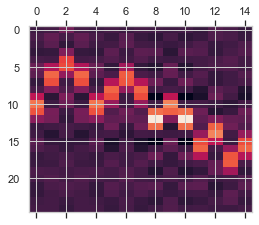

In [13]:
plt.matshow(X_train_quant[30][:, :, 0], aspect=0.5)
plt.show()

#### Create a standard Conv2D model - for compatiblility with TPU

In [14]:
# Run this if the model is already saved
model = load_model("../models/quant_model")

In [15]:
epochs, batch_size, verbose = 10, 32, 1
n_timesteps, n_features, n_outputs = X_train_quant.shape[1], X_train_quant.shape[2], y_train.shape[1]

In [14]:
# Init model
model = Sequential()

# Add layers
model.add(Conv2D(filters=64, kernel_size=(3, n_features), activation='relu', input_shape=(n_timesteps, n_features, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 1, 64)         2944      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 1, 64)         12352     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 1, 64)         12352     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 1, 64)         12352     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 1, 64)         12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 1, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)              

In [16]:
history = model.fit(X_train_quant, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/10
19643/19643 [==============================] - 118s 6ms/step - loss: 1.0695 - accuracy: 0.5833
Epoch 2/10
19643/19643 [==============================] - 111s 6ms/step - loss: 0.5493 - accuracy: 0.7876
Epoch 3/10
19643/19643 [==============================] - 111s 6ms/step - loss: 0.4506 - accuracy: 0.8320
Epoch 4/10
19643/19643 [==============================] - 111s 6ms/step - loss: 0.4048 - accuracy: 0.8520
Epoch 5/10
19643/19643 [==============================] - 111s 6ms/step - loss: 0.3764 - accuracy: 0.8644
Epoch 6/10
19643/19643 [==============================] - 110s 6ms/step - loss: 0.3594 - accuracy: 0.8717
Epoch 7/10
19643/19643 [==============================] - 111s 6ms/step - loss: 0.3431 - accuracy: 0.8792
Epoch 8/10
19643/19643 [==============================] - 112s 6ms/step - loss: 0.3340 - accuracy: 0.8834
Epoch 9/10
19643/19643 [==============================] - 111s 6ms/step - loss: 0.3245 - accuracy: 0.8873
Epoch 10/10
19643/19643 [=====================

#### Evaluate the standard (non-quantized) model

In [17]:
model.evaluate(X_test_quant, y_test, batch_size=batch_size, verbose=verbose)

6586/6586 [==============================] - 22s 3ms/step - loss: 0.5715 - accuracy: 0.8341


[0.5714851021766663, 0.8340941667556763]

In [20]:
model.save("../models/quant_model")

INFO:tensorflow:Assets written to: ../models/quant_model\assets


#### Retrain the model with quantization aware training

In [11]:
q_aware_model = quantize_model(model)
q_aware_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
q_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 25, 15, 1)         3         
_________________________________________________________________
quant_conv2d_5 (QuantizeWrap (None, 23, 1, 64)         3075      
_________________________________________________________________
quant_conv2d_6 (QuantizeWrap (None, 21, 1, 64)         12483     
_________________________________________________________________
quant_conv2d_7 (QuantizeWrap (None, 19, 1, 64)         12483     
_________________________________________________________________
quant_conv2d_8 (QuantizeWrap (None, 17, 1, 64)         12483     
_________________________________________________________________
quant_conv2d_9 (QuantizeWrap (None, 15, 1, 64)         12483     
_________________________________________________________________
quant_dropout_1 (QuantizeWra (None, 15, 1, 64)        

In [14]:
history = q_aware_model.fit(X_train_quant, y_train, epochs=1, batch_size=batch_size, verbose=verbose)

19643/19643 [==============================] - 442s 22ms/step - loss: 0.3350 - accuracy: 0.8832


In [15]:
q_aware_model.save("../models/q_aware_model")

INFO:tensorflow:Assets written to: ../models/q_aware_model\assets


INFO:tensorflow:Assets written to: ../models/q_aware_model\assets


#### Evaluate the quantization-aware model (still not actually quantized)

In [16]:
q_aware_model.evaluate(X_test_quant, y_test, batch_size=batch_size, verbose=verbose)

6586/6586 [==============================] - 51s 8ms/step - loss: 0.7179 - accuracy: 0.8304


[0.7178905010223389, 0.8304119110107422]

#### Quantize the model and evaluate

Helper function to call TFLite model on test samples:

In [22]:
def evaluate_model(interpeter):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    input_index = input_details["index"]
    output_index = output_details["index"]
    
    predictions = []
    samples = X_test_quant[::100] 
    
    for i, obs in enumerate(samples):
        print(f'Sample {i + 1}/{len(samples)}', end='\r')
        
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            obs = obs / input_scale + input_zero_point
            
        interpreter.set_tensor(input_index, [obs.astype(input_details["dtype"])])
        interpreter.invoke()
        
        output = interpreter.get_tensor(output_index)
        angle = np.argmax(output[0]) * RESOLUTION
        
        predictions.append(angle)
        
    print()
        
    predictions = np.array(predictions)
    accuracy = (predictions == df_test.label.values[::100]).mean()
    return accuracy

1) Quantization-aware model:

In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the Lite model.
with open('../models/quant_azimuth_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpnjm9bdxb\assets


INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpnjm9bdxb\assets


In [19]:
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)
test_accuracy

Sample 2108/2108


0.8325426944971537

2) Quantization-non-aware model:

In [36]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
non_aware_tflite_model = converter.convert()

# Save the Lite model.
with open('../models/non_aware_model.tflite', 'wb') as f:
    f.write(non_aware_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpckb0kmr0\assets


INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpckb0kmr0\assets


In [23]:
interpreter = tf.lite.Interpreter(model_content=non_aware_tflite_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)
test_accuracy

Sample 2108/2108


0.829696394686907

3) Non-quantized model:

In [22]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the Lite model.
with open('../models/conv_2d_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpfqlzp1oq\assets


INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpfqlzp1oq\assets


In [25]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)
test_accuracy

Sample 2108/2108


0.8282732447817837

#### Quantize inputs and outputs

In [25]:
def representative_dataset():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train_quant.astype(np.float32)).batch(1).take(100):
        yield [input_value]

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpxr_phx5v\assets


INFO:tensorflow:Assets written to: C:\Users\tkhor\AppData\Local\Temp\tmpxr_phx5v\assets


In [33]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)
test_accuracy

Sample 2108/2108


0.8273244781783681

In [34]:
interpreter.get_input_details()

[{'name': 'conv2d_5_input',
  'index': 0,
  'shape': array([ 1, 25, 15,  1]),
  'shape_signature': array([-1, 25, 15,  1]),
  'dtype': numpy.uint8,
  'quantization': (0.002377354074269533, 45),
  'quantization_parameters': {'scales': array([0.00237735], dtype=float32),
   'zero_points': array([45]),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [35]:
# Save the Lite model.
with open('../models/quant_input_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)